# Easy Money - Classification

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics

import xgboost as xgb

In [222]:
__DATA_PATH__ = "../data"
__INTERIM_DATA_PATH__ = f"{__DATA_PATH__}/interim"

TARGET = "em_acount"

DEV_PARTITION_PERIOD = ("2018-01-28", "2019-02-28")
VAL_PARTITION_PERIOD = ("2019-03-28", "2019-05-28")

# TRAIN_PERIOD = ("2018-01-28", "2018-12-28")
# TEST_PERIOD = ("2019-01-28", "2019-03-28")
# VALIDATION_PERIOD = ("2019-04-28", "2019-05-28")

exclude_columns = ["pk_cid", "pk_partition"]

## Import data

In [144]:
dtypes = {
    'pk_cid': 'int64',
    'active_customer': 'int8',
    'segment': 'int8',
    'region_code': 'int8',
    'gender': 'int8',
    'age': 'int8',
    'deceased': 'int8',
    'short_term_deposit': 'int8',
    'loans': 'int8',
    'mortgage': 'int8',
    'funds': 'int8',
    'securities': 'int8',
    'long_term_deposit': 'int8',
    'em_account_pp': 'int8',
    'credit_card': 'int8',
    'payroll': 'int8',
    'pension_plan': 'int8',
    'payroll_account': 'int8',
    'emc_account': 'int8',
    'debit_card': 'int8',
    'em_account_p': 'int8',
    'em_acount': 'int8',
    'entry_date_month': 'int8',
    'entry_date_year': 'int8',
    'entry_date_day': 'int8',
    'entry_date_week': 'int8',
    'entry_date_weekday': 'int8',
    'entry_date_trim': 'int8',
    'salary': 'float64',
    'entry_channel_KHE': 'int8',
    'entry_channel_KHQ': 'int8',
    'entry_channel_OTHERS': 'int8',
    'country_id_AR': 'int8', 'country_id_AT': 'int8', 'country_id_BE': 'int8', 'country_id_BR': 'int8',
    'country_id_CA': 'int8', 'country_id_CH': 'int8', 'country_id_CI': 'int8', 'country_id_CL': 'int8',
    'country_id_CM': 'int8', 'country_id_CN': 'int8', 'country_id_CO': 'int8', 'country_id_DE': 'int8',
    'country_id_DJ': 'int8', 'country_id_DO': 'int8', 'country_id_DZ': 'int8', 'country_id_ES': 'int8',
    'country_id_ET': 'int8', 'country_id_FR': 'int8', 'country_id_GA': 'int8', 'country_id_GB': 'int8',
    'country_id_GT': 'int8', 'country_id_HU': 'int8', 'country_id_IE': 'int8', 'country_id_IT': 'int8',
    'country_id_JM': 'int8', 'country_id_LU': 'int8', 'country_id_MA': 'int8', 'country_id_MR': 'int8',
    'country_id_MX': 'int8', 'country_id_NO': 'int8', 'country_id_PE': 'int8', 'country_id_PL': 'int8',
    'country_id_PT': 'int8', 'country_id_QA': 'int8', 'country_id_RO': 'int8', 'country_id_RU': 'int8',
    'country_id_SA': 'int8', 'country_id_SE': 'int8', 'country_id_SN': 'int8', 'country_id_US': 'int8',
    'country_id_VE': 'int8'
}
parse_dates = ['pk_partition']

In [145]:
df = pd.read_csv(f"{__INTERIM_DATA_PATH__}/easy_money_prep_1.csv", dtype=dtypes, parse_dates=parse_dates)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("entry_date", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.info(memory_usage="deep")
# df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962838 entries, 0 to 5962837
Data columns (total 74 columns):
 #   Column                Dtype         
---  ------                -----         
 0   pk_cid                int64         
 1   pk_partition          datetime64[ns]
 2   active_customer       int8          
 3   segment               int8          
 4   region_code           int8          
 5   gender                int8          
 6   age                   int8          
 7   deceased              int8          
 8   short_term_deposit    int8          
 9   loans                 int8          
 10  mortgage              int8          
 11  funds                 int8          
 12  securities            int8          
 13  long_term_deposit     int8          
 14  em_account_pp         int8          
 15  credit_card           int8          
 16  payroll               int8          
 17  pension_plan          int8          
 18  payroll_account       int8          
 19  

In [146]:
df.describe()

,pk_cid,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,mortgage,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
count,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,...,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06,5.962838e+06
mean,1.234933e+06,4.033799e-01,1.664466e+00,2.580417e+01,5.177870e-01,2.976015e+01,1.802833e-04,2.581657e-03,7.848612e-05,5.433654e-05,...,8.217564e-06,1.844759e-06,2.850991e-06,1.509348e-06,2.850991e-06,2.850991e-06,2.683286e-06,2.850991e-06,3.270255e-05,1.324872e-05
std,1.622931e+05,4.905758e-01,5.483806e-01,1.360314e+01,4.996836e-01,1.198007e+01,1.342575e-02,5.074438e-02,8.858892e-03,7.371133e-03,...,2.866618e-03,1.358218e-03,1.688486e-03,1.228555e-03,1.688486e-03,1.688486e-03,1.638072e-03,1.688486e-03,5.718521e-03,3.639856e-03
min,1.589100e+04,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.112533e+06,0.000000e+00,1.000000e+00,1.300000e+01,0.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.231097e+06,0.000000e+00,2.000000e+00,2.800000e+01,1.000000e+00,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.352340e+06,1.000000e+00,2.000000e+00,3.600000e+01,1.000000e+00,3.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.553689e+06,1.000000e+00,3.000000e+00,5.200000e+01,1.000000e+00,1.050000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962838 entries, 0 to 5962837
Data columns (total 74 columns):
 #   Column                Dtype         
---  ------                -----         
 0   pk_cid                int64         
 1   pk_partition          datetime64[ns]
 2   active_customer       int8          
 3   segment               int8          
 4   region_code           int8          
 5   gender                int8          
 6   age                   int8          
 7   deceased              int8          
 8   short_term_deposit    int8          
 9   loans                 int8          
 10  mortgage              int8          
 11  funds                 int8          
 12  securities            int8          
 13  long_term_deposit     int8          
 14  em_account_pp         int8          
 15  credit_card           int8          
 16  payroll               int8          
 17  pension_plan          int8          
 18  payroll_account       int8          
 19  

In [148]:
print(df.dtypes.to_dict())

{'pk_cid': dtype('int64'), 'pk_partition': dtype('<M8[ns]'), 'active_customer': dtype('int8'), 'segment': dtype('int8'), 'region_code': dtype('int8'), 'gender': dtype('int8'), 'age': dtype('int8'), 'deceased': dtype('int8'), 'short_term_deposit': dtype('int8'), 'loans': dtype('int8'), 'mortgage': dtype('int8'), 'funds': dtype('int8'), 'securities': dtype('int8'), 'long_term_deposit': dtype('int8'), 'em_account_pp': dtype('int8'), 'credit_card': dtype('int8'), 'payroll': dtype('int8'), 'pension_plan': dtype('int8'), 'payroll_account': dtype('int8'), 'emc_account': dtype('int8'), 'debit_card': dtype('int8'), 'em_account_p': dtype('int8'), 'em_acount': dtype('int8'), 'entry_date_month': dtype('int8'), 'entry_date_year': dtype('int8'), 'entry_date_day': dtype('int8'), 'entry_date_week': dtype('int8'), 'entry_date_weekday': dtype('int8'), 'entry_date_trim': dtype('int8'), 'salary': dtype('float64'), 'entry_channel_KHE': dtype('int8'), 'entry_channel_KHQ': dtype('int8'), 'entry_channel_OTHER

## Filter data

In [149]:
df[["pk_cid", "pk_partition", TARGET]]

,pk_cid,pk_partition,em_acount
0,15891,2018-07-28,1
1,15891,2018-08-28,0
2,16063,2018-11-28,0
3,16063,2018-12-28,0
4,16063,2019-01-28,0
...,...,...,...
5962833,1553685,2019-05-28,0
5962834,1553686,2019-05-28,0
5962835,1553687,2019-05-28,0
5962836,1553688,2019-05-28,0


In [150]:
# gb_df = df.groupby("pk_cid")
#
# gb_df.agg(
#     em_acount_count=("em_acount", sum),
#     len=("em_acount", len)
# )

In [151]:
dfilter = df[df["pk_cid"] == 46327]  #21719
dfilter[["pk_cid", "pk_partition", TARGET]]

,pk_cid,pk_partition,em_acount
1541,46327,2018-01-28,0
1542,46327,2018-02-28,0
1543,46327,2018-03-28,0
1544,46327,2018-04-28,0
1545,46327,2018-05-28,0
1546,46327,2018-06-28,0
1547,46327,2018-07-28,0
1548,46327,2018-08-28,0
1549,46327,2018-09-28,0
1550,46327,2018-10-28,0


In [152]:
dfilter

,pk_cid,pk_partition,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
1541,46327,2018-01-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,46327,2018-02-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1543,46327,2018-03-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1544,46327,2018-04-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,46327,2018-05-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1546,46327,2018-06-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,46327,2018-07-28,1,2,28,1,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1548,46327,2018-08-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1549,46327,2018-09-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1550,46327,2018-10-28,1,2,28,1,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [210]:
class EasyMoneyFilter(BaseEstimator, TransformerMixin):

    def __init__(self, target: str, group_by="pk_cid", sort_value=None):
        if sort_value is None:
            sort_value = ["pk_cid", "pk_partition"]
        self.target = target
        self.group_by = group_by
        self.sort_values = sort_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.concat([
            self.get_fist_sales(X),
            self.get_last_no_sales(X)
        ]).sort_values(self.sort_values, ignore_index=True)

    def get_fist_sales(self, X) -> pd.DataFrame:
        first_sale = X.groupby([self.group_by, self.target]).first().reset_index()
        return first_sale[first_sale[self.target] == 1]

    def get_last_no_sales(self, X) -> pd.DataFrame:
        last_no_sale = X.groupby([self.group_by, self.target]).last().reset_index()
        return last_no_sale[last_no_sale[self.target] == 0]

In [211]:
pipe = Pipeline(steps=[
    ("filter", EasyMoneyFilter(TARGET)),
])

df_prep = pipe.fit_transform(df)
df_prep.head(10)

,pk_cid,em_acount,pk_partition,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,15891,1,2018-07-28,1,0,28,1,59,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15891,0,2018-08-28,0,1,28,1,59,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16063,0,2019-05-28,0,1,28,1,62,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16203,0,2018-12-28,0,0,8,0,70,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16203,1,2019-01-28,1,1,8,0,70,0,0,...,0,0,0,0,0,0,0,0,0,0
5,16502,0,2018-09-28,0,0,28,1,57,0,0,...,0,0,0,0,0,0,0,0,0,0
6,16502,1,2018-10-28,1,1,28,1,58,0,0,...,0,0,0,0,0,0,0,0,0,0
7,17457,1,2018-01-28,1,1,28,1,53,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17590,0,2019-05-28,1,1,28,0,55,0,0,...,0,0,0,0,0,0,0,0,0,0
9,17799,1,2018-01-28,1,1,28,1,46,0,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# first_sale = df.reset_index().groupby(["pk_cid", TARGET]).first().reset_index()
# first_sale = first_sale[first_sale[TARGET] == 1]
# first_sale

In [213]:
# last_no_sale = df.reset_index().groupby(["pk_cid", TARGET]).last().reset_index()
# last_no_sale = last_no_sale[last_no_sale[TARGET] == 0]
# last_no_sale

In [214]:
# df_prep = pd.concat([first_sale, last_no_sale]).sort_values(["pk_cid", "pk_partition"], ignore_index=True)
# df_prep

In [215]:
def plot(dataframe: pd.DataFrame, target: str):
    dataframe[target].hist()
    plt.show()
    print(target)
    print(dataframe[target].value_counts())

## Target distribution

In [226]:
df_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,520984.0,1.281442e+06,179949.661207,15891.0,1149646.75,1295741.0,1428945.25,1553689.0
em_acount,520984.0,6.386511e-01,0.480392,0.0,0.00,1.0,1.00,1.0
active_customer,520984.0,4.031774e-01,0.490536,0.0,0.00,0.0,1.00,1.0
segment,520984.0,1.343218e+00,0.790100,0.0,1.00,2.0,2.00,3.0
region_code,520984.0,2.593268e+01,13.529693,-1.0,13.00,28.0,36.00,52.0
...,...,...,...,...,...,...,...,...
country_id_SA,520984.0,3.838889e-06,0.001959,0.0,0.00,0.0,0.00,1.0
country_id_SE,520984.0,5.758334e-06,0.002400,0.0,0.00,0.0,0.00,1.0
country_id_SN,520984.0,1.919445e-06,0.001385,0.0,0.00,0.0,0.00,1.0
country_id_US,520984.0,2.687223e-05,0.005184,0.0,0.00,0.0,0.00,1.0


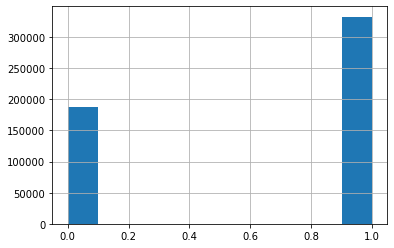

em_acount
1    332727
0    188257
Name: em_acount, dtype: int64


In [217]:
plot(df_prep, TARGET)

<AxesSubplot:xlabel='em_acount', ylabel='active_customer'>

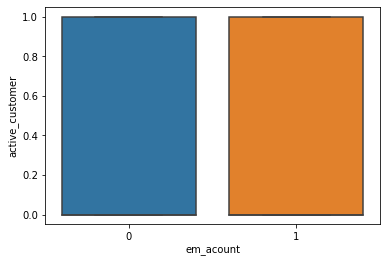

In [227]:
sns.boxplot(data=df_prep, x=TARGET, y="active_customer")

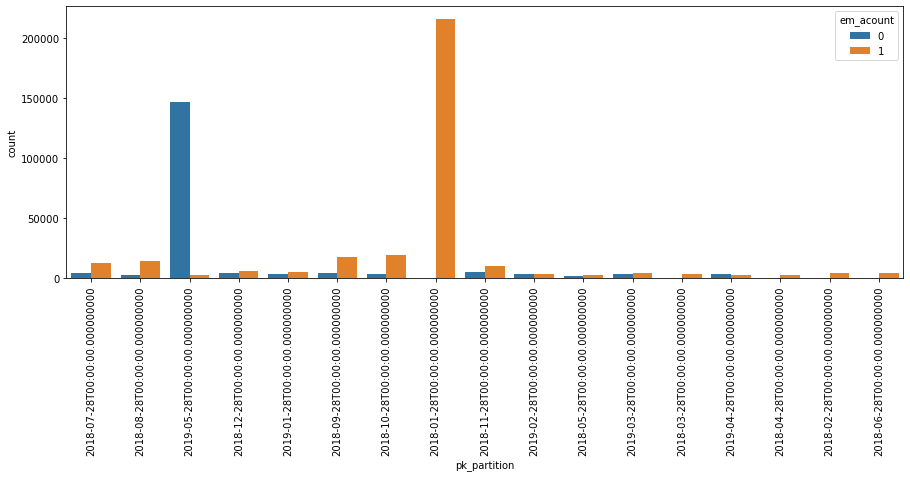

,len,sum,mean
,em_acount,em_acount,em_acount
pk_partition,,,
2018-01-28,215638,215293,0.998400
2018-02-28,4596,4156,0.904265
2018-03-28,3904,3520,0.901639
2018-04-28,3430,3003,0.875510
2018-05-28,4668,3066,0.656812
2018-06-28,5186,4711,0.908407
2018-07-28,16574,12439,0.750513
2018-08-28,16811,14129,0.840462


In [219]:
def relation_with_target(dataframe: pd.DataFrame, field: str, target: str):
    plt.figure(figsize=(15, 5))
    plt.xticks(rotation=90)
    sns.countplot(data=dataframe, x=field, hue=target)
    plt.show()
    return dataframe.pivot_table(index=field, values=target, aggfunc=[len, sum, np.mean])


relation_with_target(df_prep, "pk_partition", TARGET)

## split dataframes

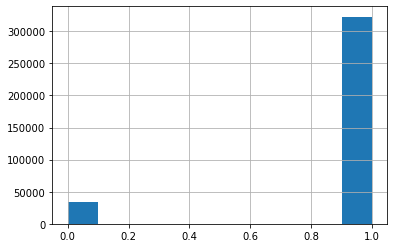

em_acount
1    322647
0     34675
Name: em_acount, dtype: int64


In [223]:
train_df = df_prep[df_prep["pk_partition"].between(DEV_PARTITION_PERIOD[0], DEV_PARTITION_PERIOD[1])].reset_index(
    drop=True)
train_df = train_df.drop(exclude_columns, axis=1)
plot(train_df, TARGET)

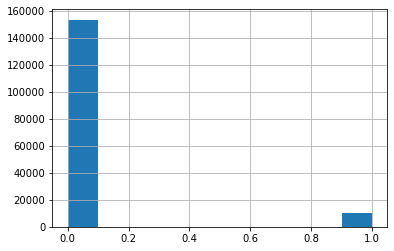

em_acount
0    153582
1     10080
Name: em_acount, dtype: int64


In [164]:
validation_df = df_prep[df_prep["pk_partition"].between(VAL_PARTITION_PERIOD[0], VAL_PARTITION_PERIOD[1])].reset_index(
    drop=True)
validation_df = validation_df.drop(exclude_columns, axis=1)
plot(validation_df, TARGET)

In [165]:
dev_X = train_df.drop(TARGET, axis=1)
dev_y = train_df[[TARGET]]

val_X = validation_df.drop(TARGET, axis=1)
val_y = validation_df[[TARGET]]

In [91]:
dev_X

,active_customer,segment,region_code,gender,age,deceased,short_term_deposit,loans,mortgage,funds,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,1,0,28,1,59,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,28,1,59,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,8,0,70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,8,0,70,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,28,1,57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357317,0,0,6,1,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
357318,0,0,46,0,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
357319,0,0,50,0,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
357320,0,0,29,0,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    dev_X,
    dev_y,
    test_size=0.2,
    random_state=13,
    stratify=dev_y
)
print(f"""
X_train.shape: {X_train.shape}
X_test.shape: {X_test.shape}
y_train.shape: {y_train.shape}
y_test.shape: {y_test.shape}
""")


X_train.shape: (285857, 71)
X_test.shape: (71465, 71)
y_train.shape: (285857, 1)
y_test.shape: (71465, 1)



## Modelling experimentation

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# clf = xgb.XGBClassifier()

from sklearn.tree import DecisionTreeClassifier as dt

clf = dt()

# grid_values = {'penalty': ['l1', 'l2'], 'C': [0.001, .009, 0.01, .09, 1, 5, 10, 25]}
# grid_clf_acc = GridSearchCV(xgb.XGBClassifier(), param_grid=grid_values, scoring='recall')
clf.fit(X_train, y_train)
#
# #Predict values based on new parameters
y_pred_acc = clf.predict(X_test)
#
# New Model Evaluation metrics
print("TEST")
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_acc)))

y_pred_acc_val = clf.predict(val_X)
print("VALIDATION")
print('Accuracy Score : ' + str(accuracy_score(val_y, y_pred_acc_val)))
print('Precision Score : ' + str(precision_score(val_y, y_pred_acc_val)))
print('Recall Score : ' + str(recall_score(val_y, y_pred_acc_val)))
print('F1 Score : ' + str(f1_score(val_y, y_pred_acc_val)))

#
# #Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test, y_pred_acc)

TEST
Accuracy Score : 0.8940460365213742
Precision Score : 0.948756736314645
Recall Score : 0.9330543933054394
F1 Score : 0.9408400525032815
VALIDATION
Accuracy Score : 0.44284562085273305
Precision Score : 0.09013452461568006
Recall Score : 0.8847222222222222
F1 Score : 0.16360150796635511


array([[ 3683,  3252],
       [ 4320, 60210]], dtype=int64)

In [107]:
from sklearn.model_selection import RandomizedSearchCV


def generate_clf_from_search(grid_or_random, clf, parameters, scorer, X, y):
    if grid_or_random == "Grid":
        search_obj = GridSearchCV(clf, parameters, scoring=scorer)
    elif grid_or_random == "Random":
        search_obj = RandomizedSearchCV(clf, parameters, scoring=scorer)
    fit_obj = search_obj.fit(X, y)
    best_clf = fit_obj.best_estimator_
    return best_clf

In [118]:
from sklearn.metrics import make_scorer

parameters = {'max_depth': [3, 4, 5, 6],
              'min_samples_leaf': [50, 100],
              # 'min_samples_split':[2,3,4,5],
              'criterion': ['gini', 'entropy']}
scorer = make_scorer(f1_score)

In [119]:
best_clf_random = generate_clf_from_search(
    "Random",
    clf,
    parameters,
    scorer,
    X_train,
    y_train
)

In [120]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_clf_random, X_train, y_train, cv=5, scoring='f1_macro')
scores.mean()

0.7896005095670462

In [125]:
best_clf_random.fit(X_train, y_train)
# Make predictions using the new model.
best_train_predictions = best_clf_random.predict(X_train)
best_test_predictions = best_clf_random.predict(X_test)
best_validation_predictions = best_clf_random.predict(val_X)

# Calculate the f1_score of the new model.
print("TEST")
print('Accuracy Score : ' + str(accuracy_score(y_test, best_test_predictions)))
print('Precision Score : ' + str(precision_score(y_test, best_test_predictions)))
print('Recall Score : ' + str(recall_score(y_test, best_test_predictions)))
print('F1 Score : ' + str(f1_score(y_test, best_test_predictions)))

print("VALIDATION")
print('Accuracy Score : ' + str(accuracy_score(val_y, best_validation_predictions)))
print('Precision Score : ' + str(precision_score(val_y, best_validation_predictions)))
print('Recall Score : ' + str(recall_score(val_y, best_validation_predictions)))
print('F1 Score : ' + str(f1_score(val_y, best_validation_predictions)))

TEST
Accuracy Score : 0.935366962848947
Precision Score : 0.949546034366324
Recall Score : 0.9805206880520688
F1 Score : 0.9647848130217664
VALIDATION
Accuracy Score : 0.3549693881291931
Precision Score : 0.07948950562371739
Recall Score : 0.8953373015873016
F1 Score : 0.14601551566532114


## Modelling

In [93]:
_MAX_DEPTH = 4
_MIN_SAMPLES_LEAF = 100
_RANDOM_STATE = 42

_MIN_CHILD_WEIGHT = 100
_N_ESTIMATORS = 50

In [94]:
model = xgb.XGBClassifier(
    max_depth=_MAX_DEPTH,
    min_child_weight=_MIN_CHILD_WEIGHT,
    n_estimators=_N_ESTIMATORS,
    random_state=_RANDOM_STATE,
    use_label_encoder=False
)

In [95]:
model.fit(X_train, y_train)

[17:09:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [96]:
accuracy = round(model.score(val_X, val_y), 4)
print('Accuracy: %0.4f' % (accuracy))

Accuracy: 0.3837


In [97]:
y_score = pd.DataFrame(model.predict_proba(X_test)[:, 1], index=y_test.index, columns=['score'])
metrics.roc_auc_score(y_test, y_score)

0.9093961315981087

Text(0, 0.5, 'TPR')

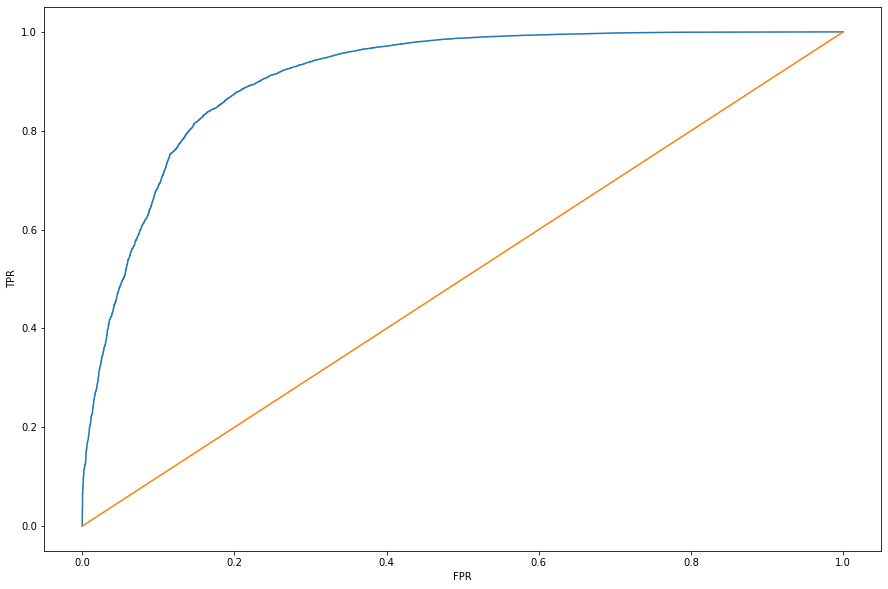

In [98]:
fpr, tpr, th = metrics.roc_curve(y_test, y_score)
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')

<AxesSubplot:>

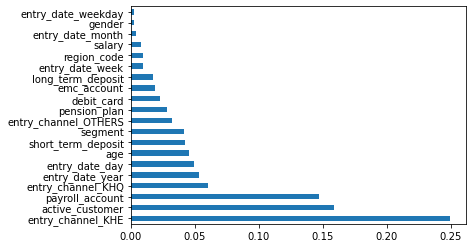

In [99]:
feat_importances = pd.Series(model.feature_importances_, index=dev_X.columns)
feat_importances.nlargest(20).plot(kind='barh')